In [1]:
"""
  This script reproduces Figure 5 in [1] Rubbens, Anne, and Taylor, Adrien B. "One-point extensions of function and operator classes."

  Given (x1,f1,g1)=(0,0,0), (x2,f2,g2)=(2,2^q/q,2^q/q), x3=1, q=3 and mu=1, it plots the allowed region
  for f3 as a function of g3, according to 
  p_{mu,q}, satisfied at {(x_i,f_i,g_i),(x_j,f_j,g_j)} if and only if:
      f_j>=f_i+<g_i,x_j-x_i>+mu/q ||x_i-x_j||^q 
  and to tilde{p}_{mu,q}, satisfied at {(x_i,f_i,g_i),(x_j,f_j,g_j),(x_k,f_k,g_k)} if and only if:
      0>=max_{0<=alpha<=1}(alpha)(-f_i+f_k+<g_k,x_i-x_k>) 
                     + (1-alpha) (-f_j+f_k+<g_k,x_i-x_k>)
           +mu/q (alpha(1-alpha)^q+(1-alpha)alpha^q)||x_i-x_j||^q+mu/q||x_k-alpha x_i-(1-alpha)x_j||^q.

"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Matplotlib is building the font cache; this may take a moment.


In [2]:
def f_min(alpha,x1,g1,f1,x2,g2,f2,x3,g3,mu,q):
    """
    Computation of tilde{p}_{mu,q}: i=1, j=2, k=3: lower bound on f3 to be maximized
    """
    y = -(f1 + g1 * (x3 - x1) + (1 - alpha) / alpha * (-f2 + f1 + g1 * (x2 - x1)) + abs(x2 - x3)**q * mu / q * (alpha**(q - 1) * (1 - alpha) + (1 - alpha)**q) + mu / q / alpha * abs(x1 - alpha * x3 - (1 - alpha) * x2)**q);
    return y


def f_max(alpha,x1,g1,f1,x2,g2,f2,x3,g3,mu,q):
    """
    Computation of tilde{p}_{mu,q}: i=3, j=2, k=1: upper bound on f3 to be minimized
    """
    y = alpha*(f1 + g3 * (x3 - x1)) + (1 - alpha)  * (f2 - g3 * (x2 - x3)) - abs(x2 - x1)**q * mu / q * (alpha**q * (1 - alpha) + alpha*(1 - alpha)**q) - mu / q  * abs(x3 - alpha * x1 - (1 - alpha) * x2)**q;
    return y


In [3]:
# Function to compute the extremal value for f3
def extremal_val_unif_conv(x1,g1,f1,x2,g2,f2,x3,g3,mu,q,constr,objective):
    """
    This function computes the extremal value for f3 such that
    {(x1, f1, g1), (x2, f2, g2), (x3, f3, g3)} satisfies p_{mu,q} or tilde{p}_{mu,q}.
    
    Arguments:
        -x1,g1,f1,x2,g2,f2,x3,g3: Dataset values with respect to which 32 has to satisfy p_{mu,q} or tilde{p}_{mu,q}.
        -mu,q: Parameters of p_{mu,q} or tilde{p}_{mu,q}.
        -constr: If constr >= 0, it ensures the set satisfies p_{mu,q}. Otherwise, it ensures the set satisfies tilde{p}_{mu,q}.
        -objective: If objective >= 0, extremal_val_unif_conv computes the minimal value for f3. Else, it computes its maximal value.
    
    Returns:
        -f3: Extremal value for f3.
    """
    options = {'disp': False}
    
    # Computation of tilde{p}_{mu,q}
    # i=1, j=2, k=3
    alpha = 1
    fun = lambda alpha: f_max(alpha,x1,g1,f1,x2,g2,f2,x3,g3,mu,q)
    res = minimize(fun, alpha, bounds=[(0, 1)], options=options)
    fmax = res.fun

    # i=3, j=2, k=1
    fun = lambda alpha: f_min(alpha,x1,g1,f1,x2,g2,f2,x3,g3,mu,q)
    res = minimize(fun, alpha, bounds=[(0, 1)], options=options)
    fmin = -res.fun

    # i=3,j=1,k=2
    fun = lambda alpha: f_min(alpha,x2,g2,f2,x1,g1,f1,x3,g3,mu,q)
    res = minimize(fun, alpha, bounds=[(0, 1)], options=options)
    fmin = max(fmin,-res.fun)
    
    # Ensuring that {((x1, f1, g1), (x2, f2, g2),(x3,f3,g3)} satisfies p_{mu,q} by bounding f3.
    bound_min = max(f1 + g1 * (x3 - x1) + mu / q * abs(x1 - x3) ** q,
                    f2 + g2 * (x3 - x2) + mu / q * abs(x2 - x3) ** q)
    bound_max = min(f1 + g3 * (x3 - x1) - mu/ q * abs(x1 - x3) ** q,
                    f2 + g3 * (x3 - x2) -mu/ q * abs(x2 - x3) ** q)
    if constr <= 0:
        bound_min = max(fmin, bound_min)        
        bound_max = min(fmax,bound_max)
        
    bounds=[(round(bound_min, 4),round(bound_max, 4))]
    # Initial value for f3
    f3_0 = 1
    # Minimization or maximization of f3
    def fun_obj(f3):
        return f3*objective

    res = minimize(fun_obj, f3_0, bounds=bounds, options={'disp': False})
    
    return res.x[0]   


In [4]:
# Dataset and parameters
q = 3
mu = 1
f1 = 0
x1 = 0
g1 = 0
f2 = mu/q * 2**q  
g2 = mu/q * 2**q 
x2 = 2
x3 = 1


# Interval of values for h3
N = 25
G3 = np.linspace(max(2/q,f2-g2+2/q),min(f2-2/q,g2-2/q),N)

# Initialize arrays for f3_min and f3_max
f3_min = np.zeros((2, N))
f3_max = np.zeros((2, N))

# Compute the extremal values for f3 as a function of g3
for i in range(N):
    f3_min[0, i] = extremal_val_unif_conv(x1,g1,f1,x2,g2,f2,x3,G3[i],mu,q,1,1)
    f3_max[0, i] = extremal_val_unif_conv(x1,g1,f1,x2,g2,f2,x3,G3[i],mu,q,1,-1)
    f3_min[1, i] = extremal_val_unif_conv(x1,g1,f1,x2,g2,f2,x3,G3[i],mu,q,-1,1)
    f3_max[1, i] = extremal_val_unif_conv(x1,g1,f1,x2,g2,f2,x3,G3[i],mu,q,-1,-1)

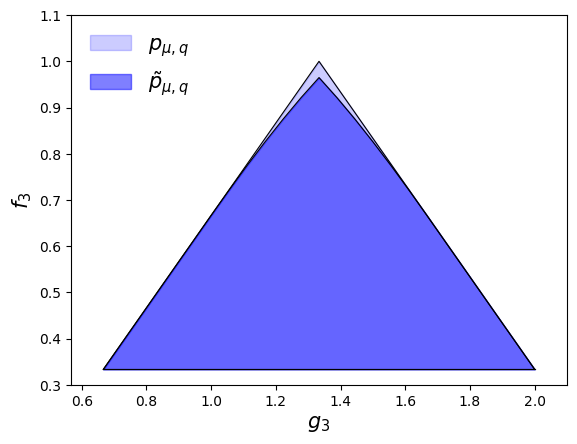

In [5]:
# Plot the result
plt.fill_between(G3, f3_min[0, :], f3_max[0, :], color='blue', alpha=0.2, label=r'$p_{\mu,q}$')
plt.fill_between(G3, f3_min[1, :], f3_max[1, :], color='blue', alpha=0.5, label=r'$\tilde{p}_{\mu,q}$')
plt.plot(G3, f3_min[0,:], color='black', linewidth=0.8)
plt.plot(G3, f3_max[0,:], color='black', linewidth=0.8)
plt.plot(G3, f3_min[1,:], color='black', linewidth=0.8) 
plt.plot(G3, f3_max[1,:], color='black', linewidth=0.8)
# Adding labels and formatting
plt.xlabel(r'$g_3$', fontsize=15)
plt.ylabel(r'$f_3$', fontsize=15)
plt.xlim([2/3-0.1,2.1])
plt.ylim([0.3,1.1])
plt.legend(fontsize=15, loc='upper left', frameon=False)
plt.show()